In [1]:
import xml.etree.ElementTree as ET
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# define the structure of a node of the tree
class Node:
    def __init__(self, label, refinement="disjunctive", comment=""):
        self.label = '"'+label+'"'
        self.refinement = refinement
        self.type, self.action, self.cost, self.role = self.comment_to_data(comment)
        
    def comment_to_data(self, comment):
        type, action, cost, role = "", "", "", ""
        
        for line in comment.split('\n'):
            if line.startswith('Type:'):
                type = line.split(': ')[1]
            elif line.startswith('Action:'):
                action = line.split(': ')[1]
            elif line.startswith('Cost:'):
                cost = line.split(': ')[1]
            elif line.startswith('Role:'):
                role = line.split(': ')[1]
                
        return type, action, cost, role
    
    def to_string(self):
        return "Label: " + self.label + "\nRefinement: " + self.refinement + "\nType: " + self.type + "\nAction: " + self.action + "\nCost: " + self.cost + "\nRole: " + self.role
            

In [3]:
# define the structure of the tree
class Tree:
    def __init__(self):
        self.root = None
        self.nodes = []
        self.edges = []
        
    def add_node(self, node):
        if self.nodes == []:
            self.root = node
        self.nodes.append(node)
        
    def add_edge(self, parent, child):
        self.edges.append((parent, child))
        
    def get_parent(self, node):
        for edge in self.edges:
            if edge[1] == node:
                return edge[0]
        return None
    
    def get_children(self, node):
        children = []
        for edge in self.edges:
            if edge[0] == node:
                children.append(edge[1])
        return children
    
    def to_string(self):
        string = ""
        for node in self.nodes:
            string += node.to_string() + "\n\n"
        return string
    
    def to_graph(self):
        G = nx.DiGraph()
        for node in self.nodes:
            G.add_node(node.label, color="Red" if node.role == "Attacker" else "green")
        for edge in self.edges:
            G.add_edge(edge[0], edge[1])
        return G
    
    def to_dataframe(self):
        data = []
        for node in self.nodes:
            data.append([node.label, node.refinement, node.type, node.action, node.cost, node.role])
        return pd.DataFrame(data, columns=["Label", "Refinement", "Type", "Action", "Cost", "Role"])
    

In [4]:
# Function to get the children of a node
def parse_children(node):
    children = []
    for child in node:
        if child.tag == 'node':
            children.append(child)
    return children

# Function to parse a node
def parse_node(node):
    refinement = node.attrib['refinement']
    label = node.find('label').text
    comment = node.find('comment').text

    return Node(label, refinement, comment)

# Function to add the children of a node to the queue
def enqueue_children(queue, children):
    return children + queue

In [5]:
xml = ET.parse('Data_Exfiltration.xml')
r = xml.find('node')

root = parse_node(r)

print(root.to_string())

Label: "Data Exfiltration"
Refinement: disjunctive
Type: Attribute
Action: 
Cost: 
Role: Attacker


In [6]:
tree = Tree()
queue = [r]

while queue:
    parent = queue.pop()
    parent_node = parse_node(parent)
    tree.add_node(parent_node)
    
    children = parse_children(parent)
    queue = enqueue_children(queue, children)
    
    for child in children:
        child_label = '"'+child.find('label').text+'"'
        tree.add_edge(parent_node.label, child_label)


In [7]:
def hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

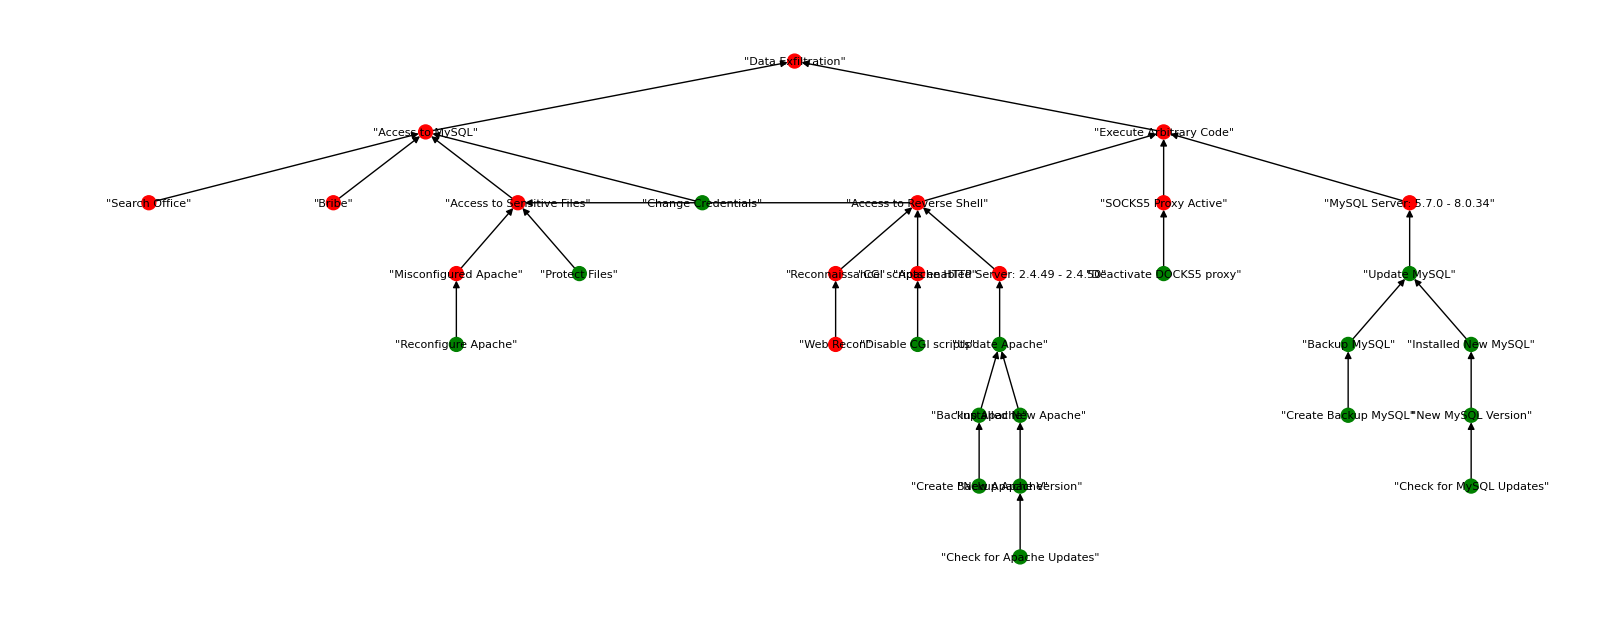

In [8]:
G = tree.to_graph()

fig = plt.figure(figsize=(16, 6))
pos = hierarchy_pos(G, tree.root.label, width=500, xcenter=0.5)   

colors = []
for node in G.nodes:
    colors.append(G.nodes[node]['color'])
    
nx.draw(nx.reverse(G), pos, node_color=colors, with_labels=True, arrows=True, node_size=100, font_size=8)
plt.show()


In [9]:
df = tree.to_dataframe()
df

,Label,Refinement,Type,Action,Cost,Role
0,"""Data Exfiltration""",disjunctive,Attribute,,,Attacker
1,"""Execute Arbitrary Code""",conjunctive,Attribute,exfiltrateData,c,Attacker
2,"""Access to MySQL""",disjunctive,Attribute,exfiltrateData,c,Attacker
3,"""MySQL Server: 5.7.0 - 8.0.34""",conjunctive,Attribute,,,Attacker
4,"""SOCKS5 Proxy Active""",conjunctive,Attribute,,,Attacker
5,"""Access to Reverse Shell""",conjunctive,Attribute,bufferOverflow,c,Attacker
6,"""Change Credentials""",disjunctive,Action,changeCredentials,c,Defender
7,"""Access to Sensitive Files""",conjunctive,Attribute,getLoginData,c,Attacker
8,"""Bribe""",conjunctive,Action,bribe,c,Attacker
9,"""Search Office""",conjunctive,Action,searchOffice,c,Attacker


In [10]:
for v in set(df["Label"].values):
    # print v without quotes and whitespaces if type=attribute
    if df.loc[df["Label"] == v, "Type"].values[0] == "Attribute":
        v = v.replace('"', "")
        v = v.replace(' ', "")
        print("global "+v+" : bool;")

global NewMySQLVersion : bool;
global DataExfiltration : bool;
global AccesstoReverseShell : bool;
global UpdateApache : bool;
global Reconnaissance : bool;
global InstalledNewMySQL : bool;
global BackupMySQL : bool;
global ExecuteArbitraryCode : bool;
global SOCKS5ProxyActive : bool;
global UpdateMySQL : bool;
global MisconfiguredApache : bool;
global NewApacheVersion : bool;
global MySQLServer:5.7.0-8.0.34 : bool;
global AccesstoSensitiveFiles : bool;
global AccesstoMySQL : bool;
global ApacheHTTPServer:2.4.49-2.4.50 : bool;
global CGIscriptsenabled : bool;
global BackupApache : bool;
global InstalledNewApache : bool;


In [11]:
# df attacker
df_attacker = df.loc[df["Role"] == "Attacker"]
df_attacker

# df defender
df_defender = df.loc[df["Role"] == "Defender"]
df_defender

for i,action in enumerate(df_defender["Action"].values):
    print("\t["+action+"] " + df_defender["Label"].values[i].replace('"', "").replace(" ", "") + " -> ")

	[changeCredentials] ChangeCredentials -> 
	[updateMySQL] UpdateMySQL -> 
	[deactivateDOCKS5Proxy] DeactivateDOCKS5proxy -> 
	[protectFiles] ProtectFiles -> 
	[rebootMySQL] InstalledNewMySQL -> 
	[] BackupMySQL -> 
	[updateApache] UpdateApache -> 
	[disableCGIscripts] DisableCGIscripts -> 
	[reconfigureApache] ReconfigureApache -> 
	[installMySQL] NewMySQLVersion -> 
	[backupMySQL] CreateBackupMySQL -> 
	[rebootApache] InstalledNewApache -> 
	[] BackupApache -> 
	[updateApache] UpdateApache -> 
	[disableCGIscripts] DisableCGIscripts -> 
	[checkMySQLUpdates] CheckforMySQLUpdates -> 
	[installApache] NewApacheVersion -> 
	[backupApache] CreateBackupApache -> 
	[rebootApache] InstalledNewApache -> 
	[] BackupApache -> 
	[checkApacheUpdates] CheckforApacheUpdates -> 
	[installApache] NewApacheVersion -> 
	[backupApache] CreateBackupApache -> 
	[checkApacheUpdates] CheckforApacheUpdates -> 
